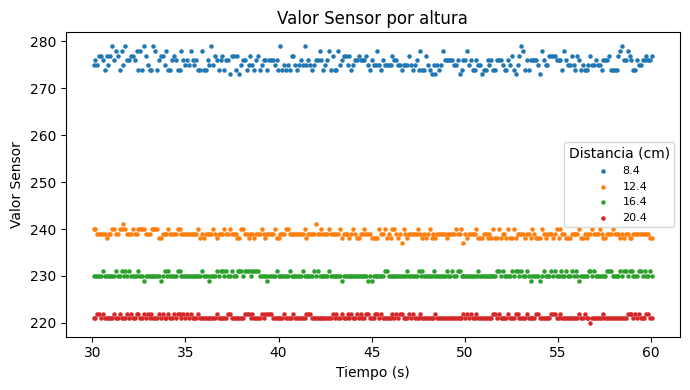

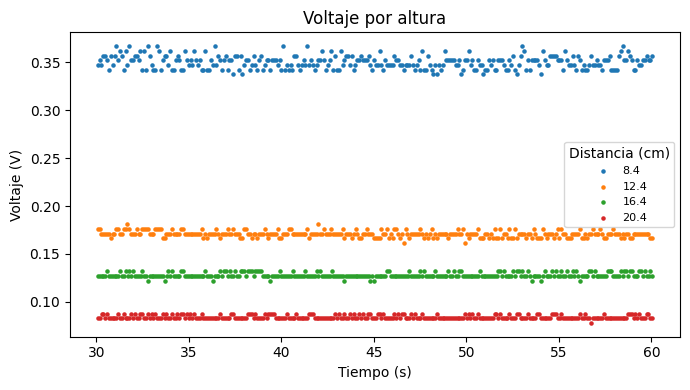

C:\Users\sebit\AppData\Local\Temp\ipykernel_1652\449464262.py:136: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


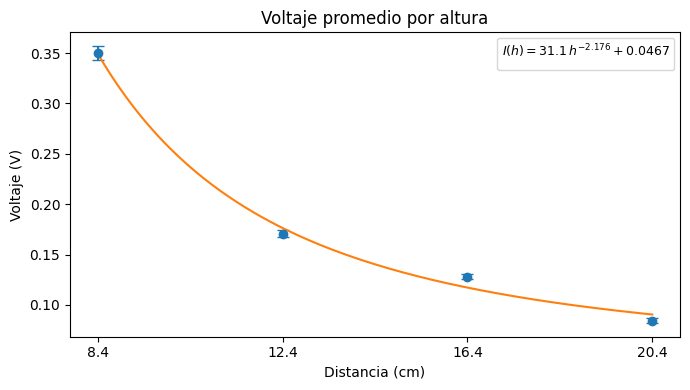

C:\Users\sebit\AppData\Local\Temp\ipykernel_1652\449464262.py:198: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


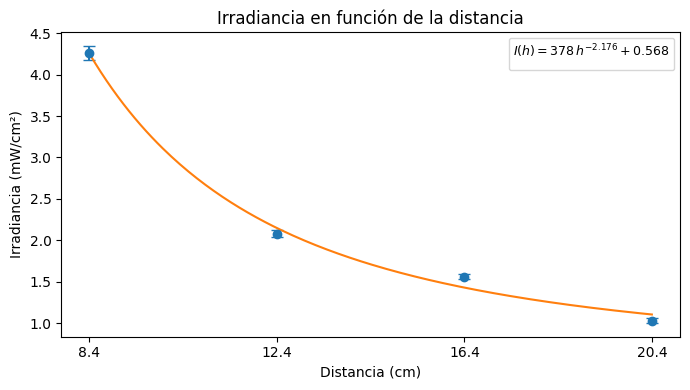

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ============================
# Cargar datos
# ============================
ruta_archivo = r"C:\Users\sebit\Desktop\Ultimo\Fuente UVB ml8511\Fuente UVB.xlsx"
df = pd.read_excel(ruta_archivo)  # si hace falta: sheet_name="Hoja1"

# Columnas esperadas:
# "Tiempo (s)", "Valor Sensor", "height", "height_name",
# "Valor_sensor_corrigido", "Voltaje", "Irradiancia (W/m²)"

# En realidad "Irradiancia (W/m²)" está en mW/cm²
df["Irradiancia (mW/cm²)"] = df["Irradiancia (W/m²)"]

# Ordenamos por altura
df = df.sort_values("height")
alturas = np.sort(df["height"].dropna().unique())

# ==========================================
# FIGURA 1: Valor Sensor por altura (scatter)
# ==========================================
plt.figure(figsize=(7, 4))

for h in alturas:
    mask = df["height"] == h
    if "height_name" in df.columns and df.loc[mask, "height_name"].notna().any():
        label = str(df.loc[mask, "height_name"].iloc[0])
    else:
        label = f"{h:g}"
    plt.scatter(
        df.loc[mask, "Tiempo (s)"],
        df.loc[mask, "Valor Sensor"],
        s=5,
        label=label
    )

plt.title("Valor Sensor por altura")
plt.xlabel("Tiempo (s)")
plt.ylabel("Valor Sensor")
plt.legend(title="Distancia (cm)", fontsize=8)
plt.tight_layout()
plt.show()

# =====================================
# FIGURA 2: Voltaje por altura (scatter)
# =====================================
plt.figure(figsize=(7, 4))

for h in alturas:
    mask = df["height"] == h
    if "height_name" in df.columns and df.loc[mask, "height_name"].notna().any():
        label = str(df.loc[mask, "height_name"].iloc[0])
    else:
        label = f"{h:g}"
    plt.scatter(
        df.loc[mask, "Tiempo (s)"],
        df.loc[mask, "Voltaje"],
        s=5,
        label=label
    )

plt.title("Voltaje por altura")
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.legend(title="Distancia (cm)", fontsize=8)
plt.tight_layout()
plt.show()

# =================================
# Función de ajuste: I(h) = K h^a + C
# =================================
def pot_con_const(h, K, a, C):
    return K * h**a + C

# ==========================================================
# Estadísticos para voltaje e irradiancia vs altura
# ==========================================================
volt_stats = df.groupby("height")["Voltaje"].agg(["mean", "std", "count"]).reset_index()
irr_stats  = df.groupby("height")["Irradiancia (mW/cm²)"].agg(["mean", "std", "count"]).reset_index()

# ------------------------------------------
# FIGURA 3: Voltaje promedio vs h (con ajuste)
# ------------------------------------------
h_v    = volt_stats["height"].values
I_v    = volt_stats["mean"].values
Ierr_v = volt_stats["std"].values

mask_v   = ~np.isnan(h_v) & ~np.isnan(I_v)
h_fit_v  = h_v[mask_v]
I_fit_v  = I_v[mask_v]

if len(I_fit_v) > 1:
    K0_v = (I_fit_v[0] - I_fit_v[-1]) * h_fit_v[0]
else:
    K0_v = 1.0
a0_v = -1.0
C0_v = I_fit_v[-1]
p0_v = [K0_v, a0_v, C0_v]

params_v, _ = curve_fit(
    pot_con_const,
    h_fit_v,
    I_fit_v,
    p0=p0_v,
    maxfev=10000
)
K_v, a_v, C_v = params_v

h_curve_v = np.linspace(h_v.min(), h_v.max(), 200)
I_curve_v = pot_con_const(h_curve_v, K_v, a_v, C_v)

plt.figure(figsize=(7, 4))

plt.errorbar(
    h_v,
    I_v,
    yerr=Ierr_v,
    fmt="o",
    capsize=4
)
plt.plot(h_curve_v, I_curve_v)

plt.title("Voltaje promedio por altura")
plt.xlabel("Distancia (cm)")      # <-- nombre nuevo
plt.ylabel("Voltaje (V)")         # <-- nombre nuevo

# ticks EXACTOS en las distancias medidas
plt.xticks(h_v, [f"{hv:g}" for hv in h_v])

# Leyenda SOLO con la ecuación I(h) = K h^a + C
eq_v = r"$I(h) = {:.3g}\,h^{{{:.3f}}} {:+.3g}$".format(K_v, a_v, C_v)
plt.legend(
    handles=[],
    labels=[],
    title=eq_v,
    loc="best",
    fontsize=8,
    title_fontsize=9
)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# FIGURA 4: Irradiancia promedio vs h (con ajuste)
# ---------------------------------------------------------
h_i    = irr_stats["height"].values
I_i    = irr_stats["mean"].values
Ierr_i = irr_stats["std"].values

mask_i   = ~np.isnan(h_i) & ~np.isnan(I_i)
h_fit_i  = h_i[mask_i]
I_fit_i  = I_i[mask_i]

if len(I_fit_i) > 1:
    K0_i = (I_fit_i[0] - I_fit_i[-1]) * h_fit_i[0]
else:
    K0_i = 1.0
a0_i = -1.0
C0_i = I_fit_i[-1]
p0_i = [K0_i, a0_i, C0_i]

params_i, _ = curve_fit(
    pot_con_const,
    h_fit_i,
    I_fit_i,
    p0=p0_i,
    maxfev=10000
)
K_i, a_i, C_i = params_i

h_curve_i = np.linspace(h_i.min(), h_i.max(), 200)
I_curve_i = pot_con_const(h_curve_i, K_i, a_i, C_i)

plt.figure(figsize=(7, 4))

plt.errorbar(
    h_i,
    I_i,
    yerr=Ierr_i,
    fmt="o",
    capsize=4
)
plt.plot(h_curve_i, I_curve_i)

plt.title("Irradiancia en función de la distancia")
plt.xlabel("Distancia (cm)")          # <-- nombre nuevo
plt.ylabel("Irradiancia (mW/cm²)")

# ticks EXACTOS en las distancias medidas
plt.xticks(h_i, [f"{hi:g}" for hi in h_i])

eq_i = r"$I(h) = {:.3g}\,h^{{{:.3f}}} {:+.3g}$".format(K_i, a_i, C_i)
plt.legend(
    handles=[],
    labels=[],
    title=eq_i,
    loc="best",
    fontsize=8,
    title_fontsize=9
)

plt.tight_layout()
plt.show()


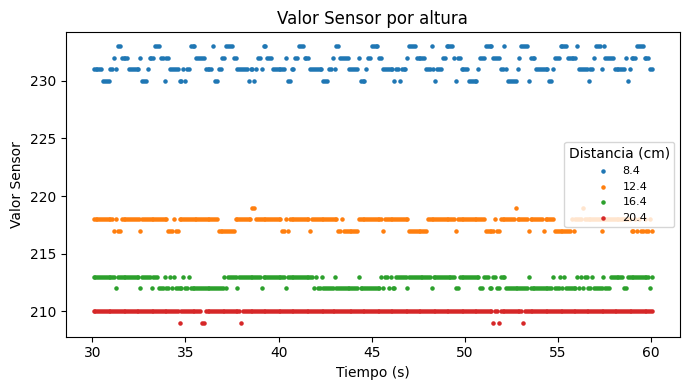

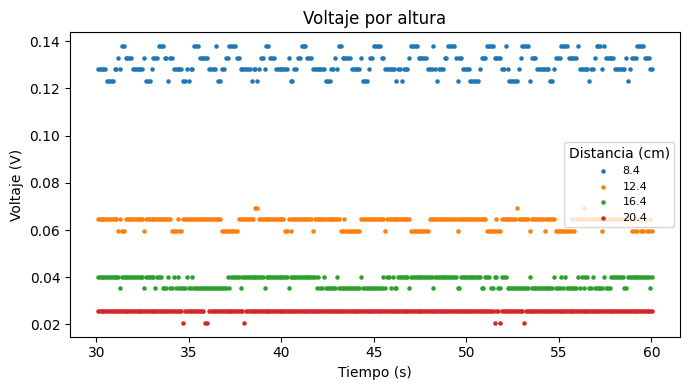

C:\Users\sebit\AppData\Local\Temp\ipykernel_1652\1611765023.py:140: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


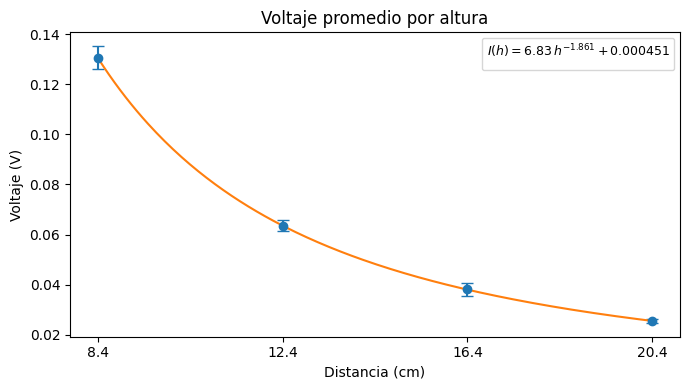

C:\Users\sebit\AppData\Local\Temp\ipykernel_1652\1611765023.py:202: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


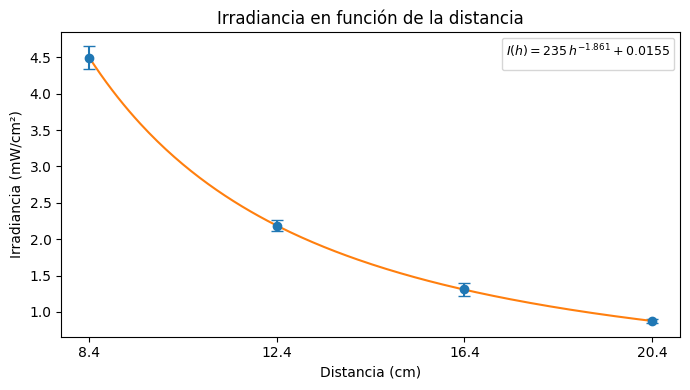

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ============================
# Cargar datos
# ============================
ruta_archivo = r"C:\Users\sebit\Desktop\Ultimo\Ossila altura ml8511\todos_datos.xlsx"
df = pd.read_excel(ruta_archivo)  # si hace falta: sheet_name="Hoja1"

# ============================
# Definir constantes K y S
# ============================
# I = K * V / S
K = 10.32   # <-- PON AQUÍ TU VALOR DE K
S = 0.3   # <-- PON AQUÍ TU VALOR DE S (≠ 0)

# Calculamos la irradiancia a partir del voltaje
# (mantenemos el nombre de la columna que usamos en los gráficos)
df["Irradiancia (mW/cm²)"] = K * df["Voltaje"] / S

# Ordenamos por altura
df = df.sort_values("height")
alturas = np.sort(df["height"].dropna().unique())

# ==========================================
# FIGURA 1: Valor Sensor por altura (scatter)
# ==========================================
plt.figure(figsize=(7, 4))

for h in alturas:
    mask = df["height"] == h
    if "height_name" in df.columns and df.loc[mask, "height_name"].notna().any():
        label = str(df.loc[mask, "height_name"].iloc[0])
    else:
        label = f"{h:g}"
    plt.scatter(
        df.loc[mask, "Tiempo (s)"],
        df.loc[mask, "Valor Sensor"],
        s=5,
        label=label
    )

plt.title("Valor Sensor por altura")
plt.xlabel("Tiempo (s)")
plt.ylabel("Valor Sensor")
plt.legend(title="Distancia (cm)", fontsize=8)
plt.tight_layout()
plt.show()

# =====================================
# FIGURA 2: Voltaje por altura (scatter)
# =====================================
plt.figure(figsize=(7, 4))

for h in alturas:
    mask = df["height"] == h
    if "height_name" in df.columns and df.loc[mask, "height_name"].notna().any():
        label = str(df.loc[mask, "height_name"].iloc[0])
    else:
        label = f"{h:g}"
    plt.scatter(
        df.loc[mask, "Tiempo (s)"],
        df.loc[mask, "Voltaje"],
        s=5,
        label=label
    )

plt.title("Voltaje por altura")
plt.xlabel("Tiempo (s)")
plt.ylabel("Voltaje (V)")
plt.legend(title="Distancia (cm)", fontsize=8)
plt.tight_layout()
plt.show()

# =================================
# Función de ajuste: I(h) = K h^a + C
# =================================
def pot_con_const(h, Kfit, afit, Cfit):
    return Kfit * h**afit + Cfit

# ==========================================================
# Estadísticos para voltaje e irradiancia vs altura
# ==========================================================
volt_stats = df.groupby("height")["Voltaje"].agg(["mean", "std", "count"]).reset_index()
irr_stats  = df.groupby("height")["Irradiancia (mW/cm²)"].agg(["mean", "std", "count"]).reset_index()

# ------------------------------------------
# FIGURA 3: Voltaje promedio vs h (con ajuste)
# ------------------------------------------
h_v    = volt_stats["height"].values
I_v    = volt_stats["mean"].values        # usamos I como variable dependiente genérica
Ierr_v = volt_stats["std"].values

mask_v   = ~np.isnan(h_v) & ~np.isnan(I_v)
h_fit_v  = h_v[mask_v]
I_fit_v  = I_v[mask_v]

if len(I_fit_v) > 1:
    K0_v = (I_fit_v[0] - I_fit_v[-1]) * h_fit_v[0]
else:
    K0_v = 1.0
a0_v = -1.0
C0_v = I_fit_v[-1]
p0_v = [K0_v, a0_v, C0_v]

params_v, _ = curve_fit(
    pot_con_const,
    h_fit_v,
    I_fit_v,
    p0=p0_v,
    maxfev=10000
)
K_v, a_v, C_v = params_v

h_curve_v = np.linspace(h_v.min(), h_v.max(), 200)
I_curve_v = pot_con_const(h_curve_v, K_v, a_v, C_v)

plt.figure(figsize=(7, 4))

plt.errorbar(
    h_v,
    I_v,
    yerr=Ierr_v,
    fmt="o",
    capsize=4
)
plt.plot(h_curve_v, I_curve_v)

plt.title("Voltaje promedio por altura")
plt.xlabel("Distancia (cm)")
plt.ylabel("Voltaje (V)")

# ticks EXACTOS en las distancias medidas
plt.xticks(h_v, [f"{hv:g}" for hv in h_v])

# Leyenda SOLO con la ecuación I(h) = K h^a + C
eq_v = r"$I(h) = {:.3g}\,h^{{{:.3f}}} {:+.3g}$".format(K_v, a_v, C_v)
plt.legend(
    handles=[],
    labels=[],
    title=eq_v,
    loc="best",
    fontsize=8,
    title_fontsize=9
)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# FIGURA 4: Irradiancia promedio vs h (con ajuste)
# ---------------------------------------------------------
h_i    = irr_stats["height"].values
I_i    = irr_stats["mean"].values
Ierr_i = irr_stats["std"].values

mask_i   = ~np.isnan(h_i) & ~np.isnan(I_i)
h_fit_i  = h_i[mask_i]
I_fit_i  = I_i[mask_i]

if len(I_fit_i) > 1:
    K0_i = (I_fit_i[0] - I_fit_i[-1]) * h_fit_i[0]
else:
    K0_i = 1.0
a0_i = -1.0
C0_i = I_fit_i[-1]
p0_i = [K0_i, a0_i, C0_i]

params_i, _ = curve_fit(
    pot_con_const,
    h_fit_i,
    I_fit_i,
    p0=p0_i,
    maxfev=10000
)
K_i, a_i, C_i = params_i

h_curve_i = np.linspace(h_i.min(), h_i.max(), 200)
I_curve_i = pot_con_const(h_curve_i, K_i, a_i, C_i)

plt.figure(figsize=(7, 4))

plt.errorbar(
    h_i,
    I_i,
    yerr=Ierr_i,
    fmt="o",
    capsize=4
)
plt.plot(h_curve_i, I_curve_i)

plt.title("Irradiancia en función de la distancia")
plt.xlabel("Distancia (cm)")
plt.ylabel("Irradiancia (mW/cm²)")

# ticks EXACTOS en las distancias medidas
plt.xticks(h_i, [f"{hi:g}" for hi in h_i])

eq_i = r"$I(h) = {:.3g}\,h^{{{:.3f}}} {:+.3g}$".format(K_i, a_i, C_i)
plt.legend(
    handles=[],
    labels=[],
    title=eq_i,
    loc="best",
    fontsize=8,
    title_fontsize=9
)

plt.tight_layout()
plt.show()


Reemplazos 0.903 -> 0.803: 300
Reemplazos 1.47  -> 1.356: 300


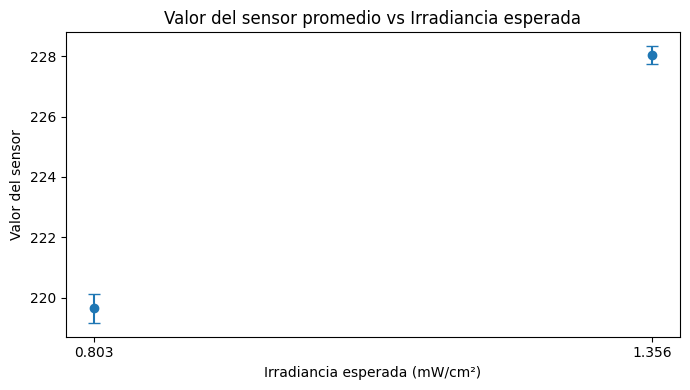

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# Cargar datos
# ============================
ruta_archivo = r"C:\Users\sebit\Desktop\Ultimo\Calibracion ml8511\Calibracion 310 nm.xlsx"   # <-- CAMBIA ESTA RUTA
df = pd.read_excel(ruta_archivo)

# Se asume que las columnas se llaman:
# 'irradiance', 'Tiempo (s)', 'Valor_sensor', 'Voltaje_sensor_corrigido'

# ==========================================
# Crear columna de Irradiancia esperada
# ==========================================
df["Irradiancia_esperada"] = df["irradiance"].astype(float)

# Reemplazos:
# 0.903 -> 0.803
# 1.47  -> 1.356
mask_0903 = np.isclose(df["Irradiancia_esperada"], 0.903, atol=1e-6)
mask_147  = np.isclose(df["Irradiancia_esperada"], 1.47,  atol=1e-6)

df.loc[mask_0903, "Irradiancia_esperada"] = 0.803
df.loc[mask_147,  "Irradiancia_esperada"] = 1.356

# (Opcional) ver cuántos se cambiaron
print("Reemplazos 0.903 -> 0.803:", mask_0903.sum())
print("Reemplazos 1.47  -> 1.356:", mask_147.sum())

# ==========================================
# Promedio y barra de error por irradiancia
# ==========================================
stats = (
    df.groupby("Irradiancia_esperada")["Valor_sensor"]
      .agg(["mean", "std", "count"])
      .reset_index()
)

# Ordenar por irradiancia
stats = stats.sort_values("Irradiancia_esperada")

x    = stats["Irradiancia_esperada"].values   # Irradiancia (mW/cm²)
y    = stats["mean"].values                   # Valor_sensor promedio
yerr = stats["std"].values                    # Barra de error = σ

# Si prefieres error estándar de la media, usa:
# yerr = stats["std"].values / np.sqrt(stats["count"].values)

# ==========================================
# Gráfico Valor_sensor promedio vs Irradiancia
# ==========================================
plt.figure(figsize=(7, 4))

plt.errorbar(
    x, y,
    yerr=yerr,
    fmt="o",
    capsize=4
)

plt.title("Valor del sensor promedio vs Irradiancia esperada")
plt.xlabel("Irradiancia esperada (mW/cm²)")
plt.ylabel("Valor del sensor")

# Mostrar en el eje x los valores EXACTOS de irradiancia
plt.xticks(x, [f"{val:g}" for val in x])

plt.tight_layout()
plt.show()



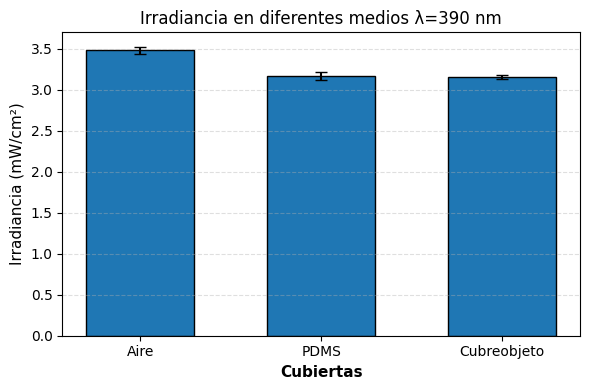

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# PARÁMETROS
# ============================
ruta_archivo = r"C:\Users\sebit\Desktop\todos_datos (1).xlsx"  # <-- cambia si hace falta
sheet_name   = 0   # o "Hoja1"

# Constantes para I = K * V / S
K = 10.32   # <-- pon aquí tu K
S = 0.30    # <-- pon aquí tu S (≠ 0)

# Longitud de onda para el título
lambda_nm = 390  # <-- modifica esto para otro λ

# Ancho de las barras (1 = sin espacio, 0.9 bastante gruesas)
bar_width = 0.6

# ============================
# Cargar datos
# ============================
df = pd.read_excel(ruta_archivo, sheet_name=sheet_name)

# ============================
# Calcular Irradiancia
# ============================
# Columna: Voltaje  -> Irradiancia (mW/cm²)
df["Irradiancia (mW/cm²)"] = K * df["Voltaje"] / S

# ============================
# Preparar nombre de las cubiertas
# ============================
# Asumimos que la columna con "Cubreobjeto", "Directo", "PDMS" es 'height_name'
df["Cubierta"] = df["height_name"].replace({"Directo": "Aire"})

# ============================
# Estadísticos por cubierta
# ============================
stats = (
    df.groupby("Cubierta")["Irradiancia (mW/cm²)"]
      .agg(["mean", "std"])
      .reset_index()
)

# ---- ORDENAR DE MAYOR A MENOR IRRADIANCIA ----
stats = stats.sort_values("mean", ascending=False)

x_pos   = np.arange(len(stats))
medias  = stats["mean"].values
errores = stats["std"].values

# ============================
# Gráfico de barras
# ============================
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(
    x_pos,
    medias,
    yerr=errores,
    width=bar_width,
    capsize=4,
    edgecolor="black"
)

ax.set_xticks(x_pos)
ax.set_xticklabels(stats["Cubierta"], fontsize=10)

ax.set_xlabel("Cubiertas", fontsize=11, fontweight="bold")
ax.set_ylabel("Irradiancia (mW/cm²)", fontsize=11)

ax.set_title(f"Irradiancia en diferentes medios λ={lambda_nm} nm", fontsize=12)

ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
# plt.savefig("irradiancia_medios_390nm.png", dpi=300, bbox_inches="tight")
